## CLEANING DATA

In [603]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer

In [604]:
#Read the data 
df=pd.read_csv('Apple-Twitter-Sentiment-DFE.csv', encoding='latin1')

In [605]:
df['sentiment'].value_counts(
)

sentiment
3               2162
1               1219
5                423
not_relevant      82
Name: count, dtype: int64

In [606]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


In [607]:
#check columns with missing vallues
df.isna().sum()

_unit_id                   0
_golden                    0
_unit_state                0
_trusted_judgments         0
_last_judgment_at        103
sentiment                  0
sentiment:confidence       0
date                       0
id                         0
query                      0
sentiment_gold          3783
text                       0
dtype: int64

In [608]:
df.duplicated().value_counts()

False    3886
Name: count, dtype: int64

In [609]:
#drop columns with missing values
df.drop(columns=['_last_judgment_at', 'sentiment_gold'],inplace=True)

In [610]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   sentiment             3886 non-null   object 
 5   sentiment:confidence  3886 non-null   float64
 6   date                  3886 non-null   object 
 7   id                    3886 non-null   float64
 8   query                 3886 non-null   object 
 9   text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 277.2+ KB


In [611]:
# create a copy of the df
df_clean=df.copy()

Most of the columns in the dataset are unnecessary as the labels provided were generated by a separate model, hence inapplicable to the work we are doing.

In [612]:
#Drop unnecessary columns
df_clean = df_clean[['text']]

In [613]:
df_clean.duplicated().value_counts()

False    3219
True      667
Name: count, dtype: int64

In [614]:
df_clean.drop_duplicates(inplace=True)

In [615]:

def clean_text(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r'http\S+|www\S+', '', text)
        # Remove mentions
        text = re.sub(r'@\w+', '', text)
        # Remove hashtags
        text = re.sub(r'#\w+', '', text)
        # Remove RT (retweet) indicator
        text = re.sub(r'^RT\s+', '', text)
        # Remove multiple spaces and strip
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        text=text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation.replace('<', '').replace('>', '')))
    return text

In [616]:
# Apply cleaning to the 'text' column
df_clean['text'] = df_clean['text'].apply(clean_text)

In [617]:
print("Before cleaning:")
print(df['text'].head())
print("\
After cleaning:")
print(df_clean['text'].head())

Before cleaning:
0    #AAPL:The 10 best Steve Jobs emails ever...htt...
1    RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2    My cat only chews @apple cords. Such an #Apple...
3    I agree with @jimcramer that the #IndividualIn...
4         Nobody expects the Spanish Inquisition #AAPL
Name: text, dtype: object
After cleaning:
0                   the 10 best steve jobs emails ever
1      why aapl stock had a miniflash crash today aapl
2                     my cat only chews cords such an 
3    i agree with that the should own not trade  it...
4               nobody expects the spanish inquisition
Name: text, dtype: object


In [618]:
df_clean.duplicated().value_counts()

False    3027
True      192
Name: count, dtype: int64

In [619]:
df_clean[df_clean.duplicated() == True]

,text
36,apple inc flash crash what you need to know
237,apples pt raised by canaccord genuity to 13500...
293,apple fibonacci technicals levels intraday u...
309,apple fibonacci technicals levels intraday u...
326,apple fibonacci technicals levels intraday u...
...,...
3871,apple is warming up to social media apple is h...
3873,apple is warming up to social media apple is h...
3874,apple is warming up to social media apple is h...
3875,apple is warming up to social media apple is h...


In [620]:
df_clean.drop_duplicates(inplace=True)

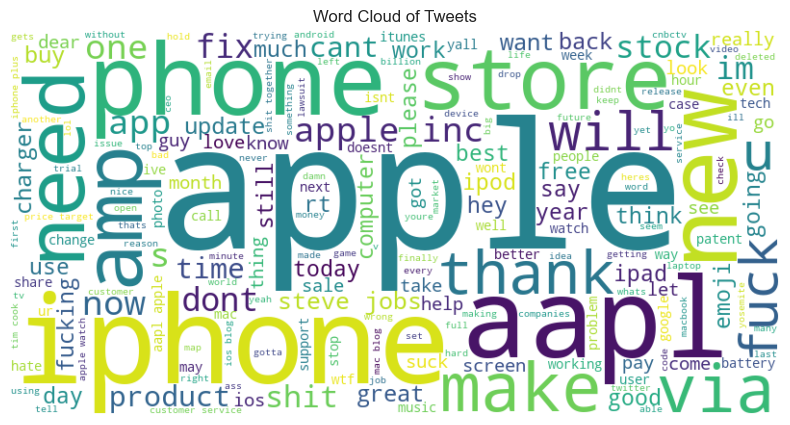

In [621]:
from wordcloud import WordCloud
# Generate Word Cloud
text = ' '.join(df_clean['text'])  # Combine all text into a single string
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Word Cloud of Tweets')
plt.show()

This word cloud visually summarizes the most common words from tweets, offering insights into
What people are talking about most frequently when discussing Apple,
Themes or topics that are top-of-mind for users and 
Possible areas of focus for sentiment analysis or further investigation into user concerns and perceptions.

### Sentiment analysis
Sentiment analysis is a natural language processing (NLP) technique used to determine the emotional tone behind a series of words. This document demonstrates how to perform sentiment analysis on a set of tweets using NLTK's `SentimentIntensityAnalyzer`.

In [622]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download the VADER lexicon for NLTK
nltk.download('vader_lexicon')


# Initializing SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to compute sentiment using NLTK's SentimentIntensityAnalyzer
def get_nltk_sentiment(tweet):
    score = sia.polarity_scores(tweet)
    return score['compound']  # Returns a value between -1 and 1

# Apply the function to the df_clean
df_clean['nltk_sentiment'] = df_clean['text'].apply(get_nltk_sentiment)

# Display the DataFrame with sentiment scores
df_clean


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/luwate/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,text,nltk_sentiment
0,the 10 best steve jobs emails ever,0.6369
1,why aapl stock had a miniflash crash today aapl,-0.4019
2,my cat only chews cords such an,0.0000
3,i agree with that the should own not trade it...,0.6597
4,nobody expects the spanish inquisition,-0.2960
...,...,...
3880,hey is it normal for my laptop charger to be s...,0.4404
3881,via fc apple is warming up to social media ap...,0.1531
3882,there is no avocado emoji may i ask why,-0.2960
3883,i could not agree more between and only great ...,0.4570


### Histogram combined with a kernel density estimate (KDE) plot & Bar chart

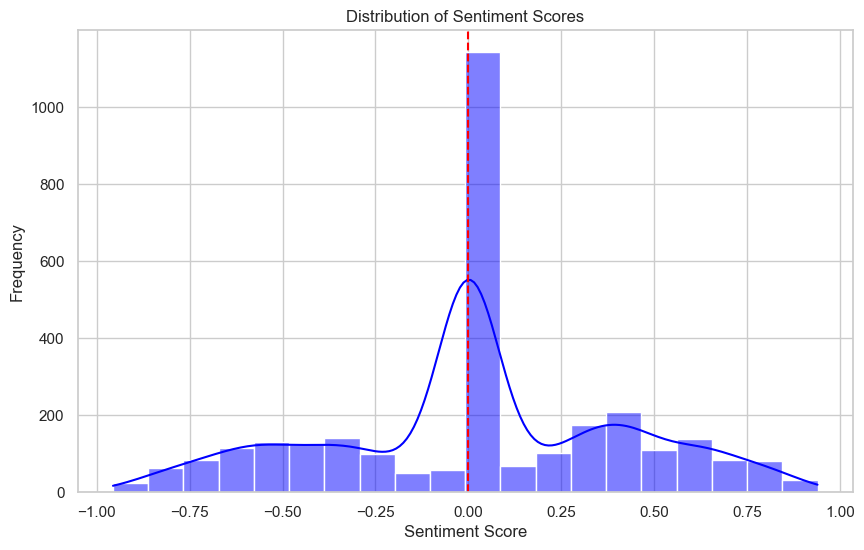

/var/folders/sh/s_xv2d8x6kv1_qyc9qgmkv300000gn/T/ipykernel_76174/2691307813.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


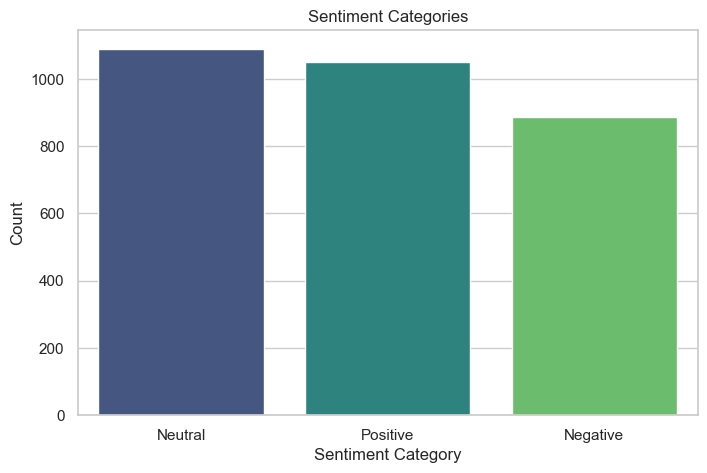

In [623]:

# Visualization

# Set the style of seaborn
sns.set(style="whitegrid")

# Histogram of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['nltk_sentiment'], bins=20, kde=True, color='blue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')  # Line for neutral sentiment
plt.show()

# Categorizing sentiment scores
def categorize_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df_clean['sentiment_category'] = df_clean['nltk_sentiment'].apply(categorize_sentiment)

# Count the number of occurrences of each sentiment category
sentiment_counts = df_clean['sentiment_category'].value_counts()

# Bar chart for sentiment categories
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

This visuals implies that most of the sentiments in the dataset are neutral, with fewer strongly negative or positive sentiments. It’s useful for understanding the overall tone of the dataset and identifying whether it skews toward positive, negative, or neutral sentiments.

In [624]:
df_clean[(df_clean['nltk_sentiment']>0.3) & (df_clean['nltk_sentiment']<0.45)].sample(15)

,text,nltk_sentiment,sentiment_category
555,new ha blog post gtgtgt final for tuesday dece...,0.3400,Positive
874,los angeles unified school district reportedly...,0.3818,Positive
2118,just watched my dad struggle to answer a call ...,0.4215,Positive
3544,i wish phones had an infinite amount of storag...,0.4019,Positive
3269,thanks for making life complicated,0.4404,Positive
995,please make a gold macbook,0.3182,Positive
2865,apple inc aapl stock in upward trend after exp...,0.4019,Positive
694,i know my iphone dies at like 20,0.3612,Positive
2938,is that a chicfilet mug hes holding my daughte...,0.4019,Positive
2779,ive seen that one looks nice too,0.4215,Positive


Upon evaluating the histogram, there is a noticeable spike in texts classified with a score of between 0.3 and 0.45. Inspecting a sample of scores in this range reveals that there has been some mis-calssification of text, which may skew the results.

In order to attempt to combat this, we can attempt to make use of a different model; specifically a K-Means model, with 3 clusters (positive, negative and neutral)

In [625]:
stopwords_list = set(stopwords.words('english')) - {'not', 'never'}
lemmatizer = WordNetLemmatizer()

In [626]:
def preprocess_text(text):
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords_list]
    return ' '.join(tokens)

df_clean['processed_text'] = df_clean['text'].apply(preprocess_text)

In [627]:
df_clean

,text,nltk_sentiment,sentiment_category,processed_text
0,the 10 best steve jobs emails ever,0.6369,Positive,10 best steve job email ever
1,why aapl stock had a miniflash crash today aapl,-0.4019,Negative,aapl stock miniflash crash today aapl
2,my cat only chews cords such an,0.0000,Neutral,cat chew cord
3,i agree with that the should own not trade it...,0.6597,Positive,agree not trade extended today pullback good see
4,nobody expects the spanish inquisition,-0.2960,Negative,nobody expects spanish inquisition
...,...,...,...,...
3880,hey is it normal for my laptop charger to be s...,0.4404,Positive,hey normal laptop charger soldering skin thanks j
3881,via fc apple is warming up to social media ap...,0.1531,Positive,via fc apple warming social medium apple hirin...
3882,there is no avocado emoji may i ask why,-0.2960,Negative,avocado emoji may ask
3883,i could not agree more between and only great ...,0.4570,Positive,could not agree great thing happen


/var/folders/sh/s_xv2d8x6kv1_qyc9qgmkv300000gn/T/ipykernel_76174/3882354597.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf', y='word', data=tfidf_df, palette='Greens_d')


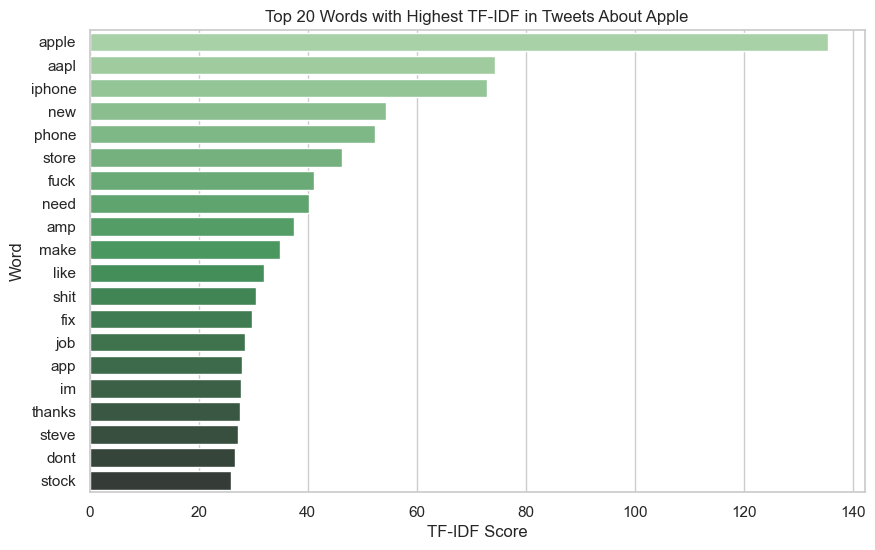

In [631]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Apply vectorizer to the text data
X = vectorizer.fit_transform(df_clean['processed_text'])

# Get the TF-IDF values
tfidf_scores = X.sum(axis=0).A1
tfidf_features = vectorizer.get_feature_names_out() 

# Create a DataFrame to store words and their TF-IDF scores
tfidf_df = pd.DataFrame({'word': tfidf_features, 'tfidf': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False).head(20)

# Plot the top 20 words with the highest TF-IDF scores
plt.figure(figsize=(10, 6))
sns.barplot(x='tfidf', y='word', data=tfidf_df, palette='Greens_d')
plt.title('Top 20 Words with Highest TF-IDF in Tweets About Apple')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.show()

The chart shows the most discussed topics, with higher bars indicating key focus areas like customer needs or product features, which can help prioritize user concerns.

In [632]:
from sklearn.cluster import KMeans

kmeans = KMeans(3, random_state=42)
clusters = kmeans.fit_predict(X)
df_clean['cluster'] = clusters

In [633]:
df_clean

,text,nltk_sentiment,sentiment_category,processed_text,cluster
0,the 10 best steve jobs emails ever,0.6369,Positive,10 best steve job email ever,0
1,why aapl stock had a miniflash crash today aapl,-0.4019,Negative,aapl stock miniflash crash today aapl,1
2,my cat only chews cords such an,0.0000,Neutral,cat chew cord,0
3,i agree with that the should own not trade it...,0.6597,Positive,agree not trade extended today pullback good see,0
4,nobody expects the spanish inquisition,-0.2960,Negative,nobody expects spanish inquisition,0
...,...,...,...,...,...
3880,hey is it normal for my laptop charger to be s...,0.4404,Positive,hey normal laptop charger soldering skin thanks j,0
3881,via fc apple is warming up to social media ap...,0.1531,Positive,via fc apple warming social medium apple hirin...,1
3882,there is no avocado emoji may i ask why,-0.2960,Negative,avocado emoji may ask,0
3883,i could not agree more between and only great ...,0.4570,Positive,could not agree great thing happen,0


<Axes: ylabel='Frequency'>

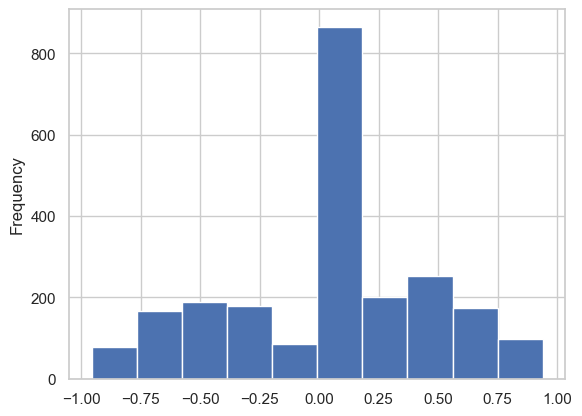

In [643]:
df_clean[df_clean['cluster'] == 0]['nltk_sentiment'].plot.hist()

<Axes: ylabel='Frequency'>

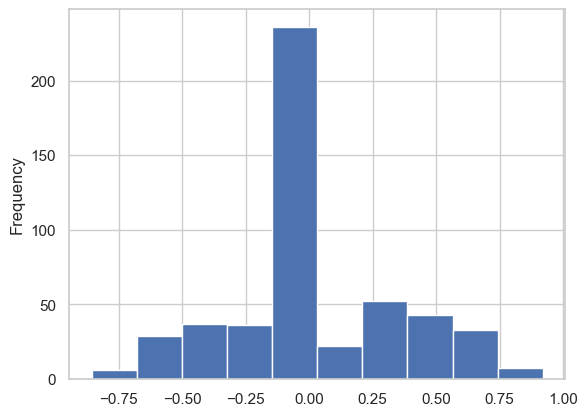

In [644]:
df_clean[df_clean['cluster'] == 1]['nltk_sentiment'].plot.hist()

<Axes: ylabel='Frequency'>

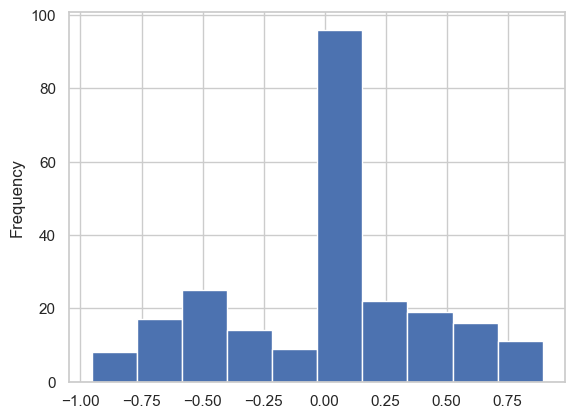

In [645]:
df_clean[df_clean['cluster'] == 2]['nltk_sentiment'].plot.hist()

The K-means model, evident by the lack of meaningful difference in distribution of nlt-scores for each cluster seems to fail to cluster the tweets in a manner that is significantly better than what the vader model was able to do.